# Tensorflow에서 제공하는 스페인->영어 번역 NMT

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


## Tokenize / Prepare train dataset


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


# Try experimenting with the size of that dataset
num_examples = 3000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(f'max_length_input={max_length_inp}')
print(f'max_length_target={max_length_targ}')

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

max_length_input=11
max_length_target=8


(2400, 2400, 600, 600)

In [6]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
12 ----> me
37 ----> gusta
11 ----> el
408 ----> rock
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
46 ----> love
386 ----> rock
3 ----> .
2 ----> <end>


In [7]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256 # dim of embedded word vector
units = 1024  # dim of GRU output
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 8]))

## Define network

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'
                                      )
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [9]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # query is last hidden of encoder'gru 
        # values is output of encoder'gru
           # shape = (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score        
        hidden_with_time_axis = tf.expand_dims(query, axis=1)
        
        # score shape = (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attension weights shape = (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context vector shape after sum = (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
        
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'
                                      )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # x is single word for decoded sentense
         # shape = (batch_size, 1)
        # hidden is previous step of decoded GRU part, or last hideen of encoder GRU
        
        # enc output shape = (batch_size, max_length, hidden_size)
        # context vector shape = (batch_size, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x shape after passing through emebedding = (batch_size, 1, embedding_size)
        x = self.embedding(x)
        
        # x shape after concatenation = (batch_size, 1, embedding_size+hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        # passing concatendated vector to the GRU
        output, state = self.gru(x)

        # output shape = (batch_size, hidden_state)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape = (batch_size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
    
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64,1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))        

Decoder output shape: (batch_size, vocab size) (64, 918)


###  Define the optimizer and the loss function

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoints (object-based)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

* Pass the input through the encoder which return encoder output and the encoder hidden state.
* The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [13]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        # first decode input is <START> token
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE, axis=1)
        
        max_targ_length = targ.shape[1]
        for t in range(1, max_targ_length):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], axis=1)
    
    batch_loss = (loss/int(targ.shape[0]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss
   

In [14]:
EPOCHS = 1

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch == 0 or batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 0.4964
Epoch 1 Loss 0.3311
Time taken for 1 epoch 40.24423813819885 sec



## Predict sentence and visualize attention

Input: <start> hace mucho frio aqui . <end>
Predicted translation:  i m gives . <end> 


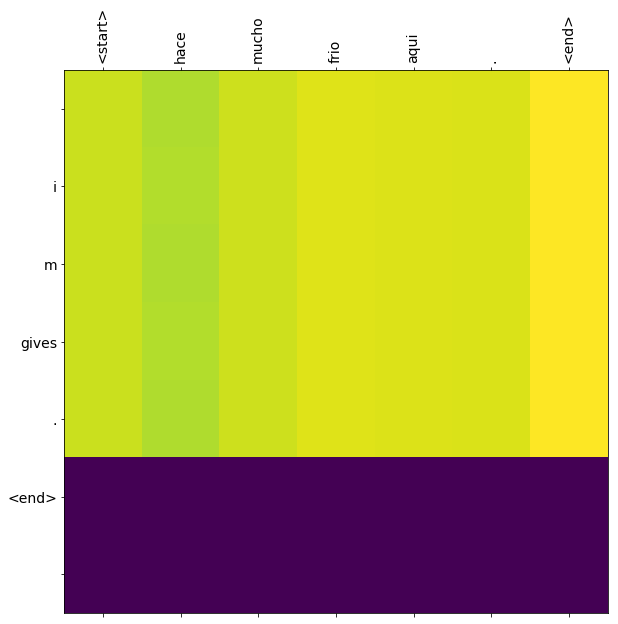

In [48]:
def evaluation(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')

    hidden = [tf.zeros((1,units))]
    enc_output, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    result = ' '
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        
        # storing attention weights for visualization
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize':14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluation(sentence)
    
    print('Input: %s' %(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    
translate(u'hace mucho frio aqui.')